In [1]:
from llm2 import *
import config as cfg
import timm
import torch
from tokenizers import Tokenizer
import torchvision.transforms as T
import torchvision.io as io
import json
import pandas as pd
import numpy as np
import os

device = 'mps'
tokenizer = Tokenizer.from_file("tokenizer.json")

/Users/saptarshimallikthakur/Pictures/VLM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chat input according to lm_chat_template 

In [2]:
print("<|im_start|>system\n"
    "You are a helpful assistant.<|im_end|>\n"
    "<|im_start|>user\n"
    "{IMAGE TOKENS}<|im_end|>\n"
    "<|im_start|>system\n"
    "Analyze the provided information and answer the following question.<|im_end|>\n"
    "<|im_start|>user\n"
    "{TEXT TOKENS}<|im_end|>\n"
    "<|im_start|>assistant\n")

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
{IMAGE TOKENS}<|im_end|>
<|im_start|>system
Analyze the provided information and answer the following question.<|im_end|>
<|im_start|>user
{TEXT TOKENS}<|im_end|>
<|im_start|>assistant



In [3]:
pad_id = tokenizer.encode("<empty_output>").ids
bos_id = tokenizer.encode("<|im_start|>").ids
eos_id = tokenizer.encode("<|im_end|>").ids
sep_id = tokenizer.encode("<file_sep>").ids
img_token_id = tokenizer.encode("<filename>").ids

system_prompt1 = tokenizer.encode(
    "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n"
).ids

system_prompt2 = tokenizer.encode(
    "<|im_end|>\n<|im_start|>system\nAnalyze the provided information and answer the following question.<|im_end|>\n<|im_start|>user\n"
).ids

# Encode the assistant prompt and separator
assistant_prompt = tokenizer.encode(
    "<|im_end|>\n<|im_start|>assistant\n"
).ids

In [4]:
IMG_SEQ_LEN = 32

class RMSNorm(torch.nn.Module):
    def __init__(self,hidden_size, eps=1e-8):
        super().__init__()
        self.hidden_size = hidden_size
        self.epsilon = eps
        self.scale = torch.nn.Parameter(torch.ones(self.hidden_size))
    
    def forward(self, x):
        rms = torch.sqrt(torch.mean(x**2,dim=-1,keepdim=True) + self.epsilon)
        norm_x = x/rms
        return norm_x * self.scale

class VLM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # --- Language Model ---
        self.decoder = LanguageModel.from_pretrained(cfg)
        self.d_model = cfg.lm_hidden_dim
        self.img_token_id = img_token_id[0]

        # --- Image Embedding Model (ViT) ---
        # Using a small ViT model as an example
        self.img_emb_model = timm.create_model('deit_tiny_distilled_patch16_224.fb_in1k', pretrained=True, features_only=True)
        self.data_config = timm.data.resolve_model_data_config(self.img_emb_model)
        self.img_feature_dim = self.img_emb_model.feature_info[-1]['num_chs'] # The feature dimension of each token

        # --- Learnable Query Tokens and Cross-Attention ---
        self.img_seq_len = IMG_SEQ_LEN
        self.learnable_queries = torch.nn.Parameter(torch.randn(1, self.img_seq_len, self.img_feature_dim))
        self.cross_attention = torch.nn.MultiheadAttention(embed_dim=self.img_feature_dim, num_heads=12, batch_first=True) 
        self.self_attention  = torch.nn.MultiheadAttention(embed_dim=self.img_feature_dim, num_heads=12, batch_first=True)

        self.self_attn_norm = RMSNorm(self.img_feature_dim)
        self.cross_attn_norm = RMSNorm(self.img_feature_dim)

        # --- Dense Projector ---
        # This now projects the ViT patch embeddings to the LLM's hidden dimension
        self.dense = torch.nn.Linear(self.img_feature_dim, self.d_model)

        # Freeze pretrained components
        for param in self.decoder.parameters():
            param.requires_grad = False
        for param in self.img_emb_model.parameters():
            param.requires_grad = False

        self.transform = T.Compose([
            T.Resize(self.data_config['input_size'][1:]),
            T.CenterCrop(self.data_config['input_size'][1:]),
            T.Normalize(mean=self.data_config['mean'], std=self.data_config['std'])
        ])

    def forward(self, inputs):
        image_paths, tokens = inputs
        pad_mask = tokens != pad_id[0]

        # --- Process Images (batch) ---
        imgs = []
        for p in image_paths:
            img = io.read_image(p)  # (C, H, W)
            if img.shape[0] == 1:   # If grayscale → repeat channels
                img = img.repeat(3, 1, 1)
            elif img.shape[0] >= 4:
                img = img[:3,:,:]
            img = img.float() / 255.0
            imgs.append(img)
        img_tensors = torch.stack([self.transform(img) for img in imgs]).to(tokens.device)

        # --- Get ViT Features ---
        vit_features = self.img_emb_model(img_tensors)[-1] 
        B, C, H, W = vit_features.shape
        vit_features = vit_features.permute(0, 2, 3, 1).reshape(B, H * W, C) 

        # --- Use Cross-Attention to get compressed image embeddings ---
        # Expand learnable queries to match the batch size
        batch_size = vit_features.shape[0]
        batch_queries = self.learnable_queries.expand(batch_size, -1, -1)
        
        # Q: learnable_queries, K & V: projected_vit_features
        batch_queries    = self.cross_attn_norm(batch_queries)
        img_emb_cross, _ = self.cross_attention(query=batch_queries, key=vit_features, value=vit_features)
        img_emb          = img_emb_cross + batch_queries

        img_emb       = self.self_attn_norm(img_emb)
        img_emb_sa, _ = self.self_attention(query=img_emb, key=img_emb, value=img_emb)
        img_emb       = img_emb + img_emb_sa

        # --- Project ViT features to LLM's dimension ---
        img_emb = self.dense(img_emb)

        # --- Project and Combine Embeddings ---
        text_emb = self.decoder.token_embedding(tokens)
        final_embeddings = text_emb
    
        placeholder_mask = (tokens == self.img_token_id)

        # Sanity check: Ensure the number of placeholders matches the number of image embeddings
        num_placeholders = placeholder_mask.sum(dim=1)
        if not torch.all(num_placeholders == self.img_seq_len):
            raise ValueError(f"The number of image placeholder tokens in the input ({num_placeholders.tolist()}) "
                             f"does not match the expected number of image embeddings ({self.img_seq_len}).")

        # We replace the embeddings at the masked locations.
        # The shape of `final_embeddings[placeholder_mask]` will be (B * img_seq_len, d_model), 
        # The shape of `img_emb` is (B, img_seq_len, d_model), so we reshape it to match.
        final_embeddings[placeholder_mask] = img_emb.reshape(-1, self.d_model)

        logits = self.decoder(final_embeddings, attention_mask=pad_mask)
        return logits
    
    @torch.inference_mode()
    def generate(self, inputs, max_new_tokens=30, temp=0.5):
        image_paths, tokens = inputs

        # --- Process Images (batch) with ViT and Cross-Attention ---
        imgs = []
        for p in image_paths:
            img = io.read_image(p)  # (C, H, W)
            if img.shape[0] == 1:   # If grayscale → repeat channels
                img = img.repeat(3, 1, 1)
            elif img.shape[0] >= 4:
                img = img[:3,:,:]
            img = img.float() / 255.0
            imgs.append(img)
        img_tensors = torch.stack([self.transform(img) for img in imgs]).to(tokens.device)

        # 1. Get ViT patch embeddings
        vit_features = self.img_emb_model(img_tensors)[-1]
        B, C, H, W = vit_features.shape
        vit_features = vit_features.permute(0, 2, 3, 1).reshape(B, H * W, C) 

        # 2. Use cross-attention with learnable queries to get the final image embeddings
        # Expand learnable queries to match the batch size
        batch_size = vit_features.shape[0]
        batch_queries = self.learnable_queries.expand(batch_size, -1, -1)
        
        # The learnable queries "ask" for information from the image features
        batch_queries    = self.cross_attn_norm(batch_queries)
        img_emb_cross, _ = self.cross_attention(query=batch_queries, key=vit_features, value=vit_features)
        img_emb          = img_emb_cross + batch_queries

        img_emb       = self.self_attn_norm(img_emb)
        img_emb_sa, _ = self.self_attention(query=img_emb, key=img_emb, value=img_emb)
        img_emb       = img_emb + img_emb_sa
        
        # project to llm space
        img_emb = self.dense(img_emb)

        # --- Prepare for Generation ---
        text_emb = self.decoder.token_embedding(tokens)
        final_embeddings = text_emb

        placeholder_mask = (tokens == self.img_token_id)

        num_placeholders = placeholder_mask.sum(dim=1)
        if not torch.all(num_placeholders == self.img_seq_len):
            raise ValueError(f"The number of image placeholder tokens in the input ({num_placeholders.tolist()}) "
                             f"does not match the expected number of image embeddings ({self.img_seq_len}).")

        final_embeddings[placeholder_mask] = img_emb.reshape(-1, self.d_model)

        # --- Autoregressive Generation Loop ---
        generated_outputs = final_embeddings
        newly_generated_ids_list = []

        for i in range(max_new_tokens):
            # Forward pass
            prompt_output = self.decoder(generated_outputs, attention_mask=None)
            last_output = prompt_output[:, -1, :] / temp

            # --- Apply top-k / top-p filtering ---
            filtered_logits = top_k_top_p_filtering(last_output, top_k=50, top_p=0.9)

            # Sample next token
            next_token = torch.distributions.Categorical(logits=filtered_logits).sample().unsqueeze(1)

            # Append to sequence
            newly_generated_ids_list.append(next_token)
            next_emb = self.decoder.token_embedding(next_token)
            generated_outputs = torch.cat((generated_outputs, next_emb), dim=1)

            # Check for EOS
            if next_token.item() == 2:  # EOS token ID
                break

        return newly_generated_ids_list
    

def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf")):
    # top_k filtering
    if top_k > 0:
        top_k = min(top_k, logits.size(-1))  # safety
        threshold = torch.topk(logits, top_k)[0][..., -1, None]
        logits = torch.where(logits < threshold, filter_value, logits)
    
    # top_p (nucleus) filtering
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        probs = F.softmax(sorted_logits, dim=-1)
        cumulative_probs = torch.cumsum(probs, dim=-1)

        # remove tokens with cumulative probability above threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # keep the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = False

        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits = logits.masked_fill(indices_to_remove, filter_value)

    return logits

In [5]:
df = pd.read_csv('/Users/saptarshimallikthakur/Pictures/vik_lnqa/all_train_qa.csv')
df = df.rename(columns={'image_path':'img_path','question':'input_text','answer':'target_text'})
df['img_path'] = df['img_path'].apply(lambda x: '/Users/saptarshimallikthakur/Pictures/vik_lnqa/' + x)
df

,img_path,input_text,target_text
0,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What can be seen on the road in the image?,There are cars on the road in the image.
1,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What type of natural environment is visible on...,"There is grassland on either side of the road,..."
2,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What type of structure can be seen in the back...,There is a palace in the background of the image.
3,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What part of the natural environment is visibl...,"The sky is visible in the image, and clouds ar..."
4,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,Can you tell me how many pipes are visible in ...,There are no pipes present in the image.
...,...,...,...
283713,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What can be seen on the side of the road?,There are buildings visible on the side of the...
283714,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What type of vegetation is present in the image?,There are trees in the image.
283715,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What is providing light in the image?,There is a pole light in the image.
283716,/Users/saptarshimallikthakur/Pictures/vik_lnqa...,What type of brass instrument is being played ...,There is no brass instrument or scene present ...


In [6]:
import re

def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    # text = text.lower()
    text = re.sub(r'<image>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df['target_text'] = df['target_text'].apply(lambda x: clean_text(x))
df['input_text'] = df['input_text'].apply(lambda x: clean_text(x))

100%|██████████| 283718/283718 [00:11<00:00, 25580.91it/s]

Total samples    : 283,718
Min / Max tokens : 10 / 694
Mean ± std       : 23.2 ± 8.1
--- percentiles (tokens) ---
 50% : 21
 90% : 34
 95% : 37
 98% : 41
 99% : 45


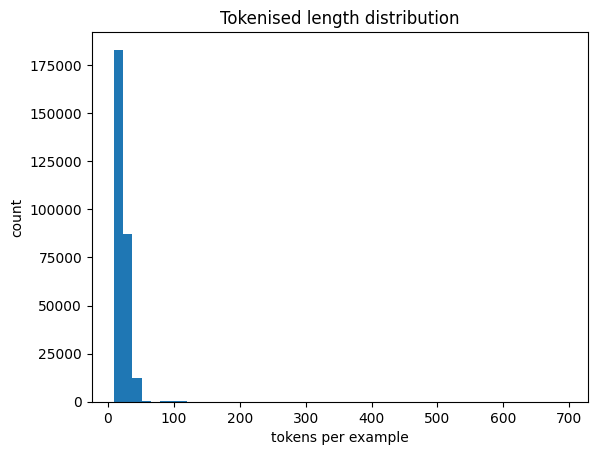

In [7]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s, d in tqdm(zip(df["input_text"], df["target_text"]),
                 total=len(df)):
    iids   = tok.encode(s).ids
    tids   = tok.encode(d).ids
    
    lens.append(len(iids+tids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [8]:
prompt = (
    "<|im_start|>system\n"
    "You are a helpful assistant.<|im_end|>\n"
    "<|im_start|>user\n"
    "{IMAGE TOKENS}<|im_end|>\n"
    "<|im_start|>system\n"
    "Analyze the provided information and answer the following question.<|im_end|>\n"
    "<|im_start|>user\n"
    "{TEXT TOKENS}<|im_end|>\n"
    "<|im_start|>assistant\n"
)

MAX_LEN = IMG_SEQ_LEN + int(pct(99)) + len(tokenizer.encode(prompt).ids)
MAX_INPUT_LEN = 256
BATCH_SIZE = 32

def encode_pair(text_a: str, text_b: str) -> np.ndarray:
    # Add image tokens
    image_tokens = img_token_id * IMG_SEQ_LEN

    # Encode the first user input
    user_input = tokenizer.encode(text_a).ids

    # Encode the second user input
    assistant_response = tokenizer.encode(text_b).ids

    # Combine all parts
    encoded = system_prompt1 + image_tokens + system_prompt2 + user_input + assistant_prompt + sep_id + assistant_response

    # Truncate to maximum length
    return encoded[:MAX_LEN]

def encode_example(img_path, text: str, summary: str):
    ids    = encode_pair(text, summary)     
    labels = ids[1:]

    ids = ids + pad_id*(MAX_LEN-len(ids))
    
    labels = labels + eos_id 
    labels = labels + pad_id*(MAX_LEN-len(labels))

    ids    = np.array(ids,dtype=np.int32)
    labels = np.array(labels,dtype=np.int32)

    # find SEP
    SEP_idxs = np.where(labels == sep_id)[0]
    SEP_pos  = int(SEP_idxs[0]) if SEP_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    loss_mask = (positions > SEP_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    # Remove SEP from ids, labels, and loss_mask
    sep_mask_ids    = (ids != sep_id[0])
    sep_mask_labels = (labels != sep_id[0])
    
    ids       = ids[sep_mask_ids]
    labels    = labels[sep_mask_labels]
    loss_mask = loss_mask[sep_mask_labels]

    return img_path, ids, labels.astype(np.int32), loss_mask

In [9]:
from torch.utils.data import Dataset, DataLoader,Sampler
import random

TOTAL_STEPS = 2500
num_training_samples = TOTAL_STEPS * BATCH_SIZE

class MyDataset(Dataset):
    def __init__(self, img_path, ids, labels, masks):
        self.img_path = img_path
        self.ids = ids
        self.labels = labels
        self.masks = masks

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return {
            "img_path": self.img_path[idx],   # string
            "input_ids": self.ids[idx],
            "labels": self.labels[idx],
            "loss_mask": self.masks[idx]
        }
    
class RandomStepSampler(Sampler):
    """
    A sampler that yields a random index from the dataset for a specified
    number of steps. This performs sampling with replacement for each item.
    """
    def __init__(self, data_source, num_samples):
        self.data_source = data_source
        # Total number of items to sample (not batches)
        self.num_samples = num_samples

    def __iter__(self):
        n = len(self.data_source)
        for _ in range(TOTAL_STEPS):  # One loop per batch
            batch_indices = random.sample(range(n), BATCH_SIZE)  # Unique within batch
            yield from batch_indices  # Yield them in random order

    def __len__(self):
        return self.num_samples
    
triples = [encode_example(row.img_path, row.input_text, row.target_text) for _, row in df.iterrows()]

# Unpack
img_path, ids, labels, masks = zip(*triples)

# Keep img_path as a list (strings cannot be tensors)
img_path = list(img_path)

# Convert others to tensors
ids = torch.tensor(np.stack(ids, 0), dtype=torch.long)
labels = torch.tensor(np.stack(labels, 0), dtype=torch.long)
masks = torch.tensor(np.stack(masks, 0), dtype=torch.long)


dataset = MyDataset(img_path, ids, labels, masks)
step_sampler = RandomStepSampler(dataset, num_samples=num_training_samples)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=step_sampler)

del(triples)
del(img_path)
del(ids)
del(labels)
del(masks)
del(df)
del(dataset)

In [10]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tok = id_to_token.get(tid, '?')
        if tok == '$':
            continue  # Skip the '$' symbol
        if tok.startswith('Ġ'):
            tok = tok[1:]  # Remove the space prefix indicator
            tokens.append(' ' + tok)
        else:
            tokens.append(tok)
    return ' '.join(tokens).strip()

for batch_idx, batch in enumerate(dataloader):
    if batch_idx >= 10:  # Equivalent to .take(10)
        break
    
    # Extract batch data
    img_paths = batch['img_path']           # list of strings
    input_ids = batch['input_ids'].numpy()  # shape (batch, MAX_LEN)
    labels    = batch['labels'].numpy()     # shape (batch, MAX_LEN)

    for i, (pth, ids_row, lbl_row) in enumerate(zip(img_paths, input_ids, labels), start=1):
        print(f"\n🟢 Sample {i}")
        print("  pth: ", pth)
        print("  Input IDs: ", ids_row.tolist())
        print("  Input:   ", decode_token_ids(ids_row.tolist()))
        print(" Target:   ", decode_token_ids(lbl_row.tolist()))
        print("  Label IDs: ", lbl_row.tolist())


🟢 Sample 1
  pth:  /Users/saptarshimallikthakur/Pictures/vik_lnqa/train-00012-of-00199/4e4ed52d41603cec.jpg
  Input IDs:  [1, 9690, 198, 2683, 359, 253, 5356, 11173, 30, 2, 198, 1, 4093, 198, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 198, 1, 9690, 198, 24499, 2404, 260, 2711, 1096, 284, 2988, 260, 1695, 1962, 30, 2, 198, 1, 4093, 198, 5588, 314, 6178, 281, 260, 6376, 281, 260, 2443, 47, 2, 198, 1, 520, 9531, 198, 1195, 6376, 314, 6178, 281, 260, 3969, 282, 260, 2443, 30, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
  Input:    <|im_start|> system Ċ You  are  a  helpful  assistant . <|im_end|> Ċ <|im_start|> user Ċ <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <filename> <file

In [11]:
print(batch["input_ids"][1])
print(batch["labels"][1])
print(batch["loss_mask"][1])

tensor([    1,  9690,   198,  2683,   359,   253,  5356, 11173,    30,     2,
          198,     1,  4093,   198,     6,     6,     6,     6,     6,     6,
            6,     6,     6,     6,     6,     6,     6,     6,     6,     6,
            6,     6,     6,     6,     6,     6,     6,     6,     6,     6,
            6,     6,     6,     6,     6,     6,     2,   198,     1,  9690,
          198, 24499,  2404,   260,  2711,  1096,   284,  2988,   260,  1695,
         1962,    30,     2,   198,     1,  4093,   198,  5588,   416,   325,
         2269,  1130,   260, 25901,    47,     2,   198,     1,   520,  9531,
          198, 11527,   359,  3498,  3417,  1130,   260, 25901,    30,    16,
           16,    16,    16,    16,    16,    16,    16,    16,    16,    16,
           16,    16,    16,    16,    16,    16,    16,    16,    16,    16,
           16,    16,    16,    16,    16,    16,    16,    16,    16,    16,
           16,    16,    16,    16,    16,    16,    16,    16, 

In [12]:
# Build and load VLM
vlm = VLM()
vlm.to(device)

dummy_path = ["/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"]
dummy_tokens = batch['input_ids'][:1].to(device)
_ = vlm((dummy_path,dummy_tokens))

print("Trainable Parameters:")
print("-" * 60)
total_params = 0
for name, param in vlm.named_parameters():
    if param.requires_grad:
        param_count = param.numel()
        print(f"Parameter: {name:<50} Shape: {str(param.shape):<20} Parameters: {param_count}")
        total_params += param_count
print("-" * 60)
print(f"Total Trainable Parameters: {total_params:,}")

Extending token embeddings from torch.Size([49152, 576]) to torch.Size([49218, 576])
Initialized 66 new token embeddings
Successfully loaded smollm2-135m weights from safetensors. Model has 134,553,024 parameters.
Trainable Parameters:
------------------------------------------------------------
Parameter: learnable_queries                                  Shape: torch.Size([1, 32, 192]) Parameters: 6144
Parameter: cross_attention.in_proj_weight                     Shape: torch.Size([576, 192]) Parameters: 110592
Parameter: cross_attention.in_proj_bias                       Shape: torch.Size([576])    Parameters: 576
Parameter: cross_attention.out_proj.weight                    Shape: torch.Size([192, 192]) Parameters: 36864
Parameter: cross_attention.out_proj.bias                      Shape: torch.Size([192])    Parameters: 192
Parameter: self_attention.in_proj_weight                      Shape: torch.Size([576, 192]) Parameters: 110592
Parameter: self_attention.in_proj_bias          

In [13]:
from torch.optim.lr_scheduler import _LRScheduler
import math
from tqdm import tqdm
import torch

class CustomLRScheduler(_LRScheduler):
    def __init__(self, optimizer, total_steps, warmup_steps_ratio, min_lr, max_lr, last_epoch=-1):
        self.total_steps = total_steps
        self.warmup_steps = int(total_steps * warmup_steps_ratio)
        self.min_lr = min_lr
        self.max_lr = max_lr
        super(CustomLRScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        current_step = self.last_epoch
        if current_step < self.warmup_steps:
            lr = self.min_lr + (self.max_lr - self.min_lr) * (current_step / self.warmup_steps)
        else:
            progress = (current_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            decay_factor = math.exp(-1.0 * progress)
            lr = self.min_lr + (self.max_lr - self.min_lr) * decay_factor
            lr = max(lr, self.min_lr)
        return [lr for _ in self.base_lrs]
    
LEARNING_RATE_MIN = 1e-4
LEARNING_RATE_MAX = 1e-4
WARMUP_RATIO = 0

# --- Optimizer ---
optimizer = torch.optim.Adam(vlm.parameters(), lr=LEARNING_RATE_MAX, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(reduction='none')  
scheduler = CustomLRScheduler(
    optimizer,TOTAL_STEPS,
    warmup_steps_ratio=WARMUP_RATIO,
    min_lr=LEARNING_RATE_MIN,
    max_lr=LEARNING_RATE_MAX
)

vlm.train()
tot_loss = tot_correct = tot_tokens = 0.0

pbar = tqdm(dataloader, desc="Training Steps", total=TOTAL_STEPS)
for batch in pbar:
    paths = batch['img_path']
    ids = batch["input_ids"].to(device)          # (B, T)
    tgt = batch["labels"].to(device)             # (B, T)
    mask = batch["loss_mask"].to(device)         # (B, T)

    optimizer.zero_grad()
    logits = vlm((paths,ids))                          # (B, T, V)

    # ---- loss ----
    loss = criterion(logits.view(-1, logits.size(-1)), tgt.view(-1))  # (B*T,)
    masked_loss = (loss * mask.view(-1)).sum() / mask.sum().clamp(min=1)  # Apply mask and average
    masked_loss.backward()
    # torch.nn.utils.clip_grad_norm_(vlm.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

    # ---- metrics (no grad) ----
    with torch.no_grad():
        preds = logits.argmax(-1)                # (B, T)
        valid = (mask == 1.0)                    # bool mask where loss_mask is 1.0
        correct = (preds == tgt) & valid         # Correct predictions where mask is 1.0
        n_tok = valid.sum().item()               # Count of masked tokens

        tot_correct += correct.sum().item()
        tot_tokens += n_tok
        tot_loss += masked_loss.item() * n_tok   # Scale by number of valid tokens

    pbar.set_postfix(
        loss=f"{tot_loss / tot_tokens:.4f}" if tot_tokens > 0 else "N/A",
        acc=f"{tot_correct / tot_tokens:.4f}" if tot_tokens > 0 else "N/A",
        lr=f"{scheduler.get_last_lr()[0]:.6f}"
    )

Training Steps: 100%|██████████| 2500/2500 [1:48:31<00:00,  2.60s/it, acc=0.7143, loss=1.2359, lr=0.000100]


In [14]:
import cv2

def encode(text: str) -> list[int]:
    # Add image tokens
    image_tokens = img_token_id * IMG_SEQ_LEN

    # Encode the first user input9
    user_input = tokenizer.encode(text).ids

    full_ids = system_prompt1 + image_tokens + system_prompt2 + user_input + assistant_prompt
    return full_ids

def generate_answer(model,image_path,question,max_tokens=30, temp=0.5):
    prompt_ids = encode(clean_text(question))
    text_tokens = torch.tensor([prompt_ids], dtype=torch.int32).to(device)
    output = model.generate(([image_path], text_tokens),max_new_tokens=max_tokens, temp=temp)

    # Display image for context
    imgbgr = cv2.imread(image_path)
    if imgbgr is not None:
        imgrgb = cv2.cvtColor(imgbgr,cv2.COLOR_BGR2RGB)
        plt.imshow(imgrgb)
        plt.title(f"Q: {question}")
        plt.axis('off')
        plt.show()

    return tokenizer.decode(output).strip()

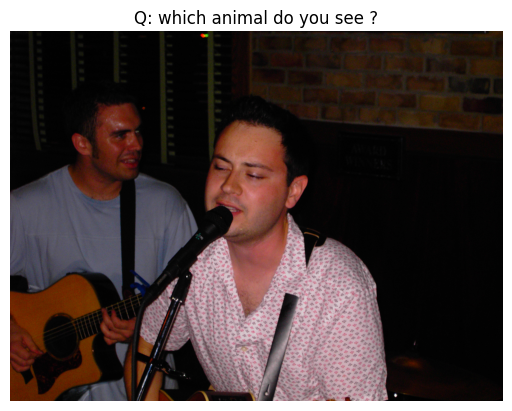

there is no animal present in the image.


In [15]:
img   = '/Users/saptarshimallikthakur/Pictures/VLM/nanovlm/vikhyatk_inqa/train-00000-of-00199/753c0955fa7028c5.jpg' #"/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "which animal do you see ?"
print(generate_answer(vlm, img, ques, temp=1.0))

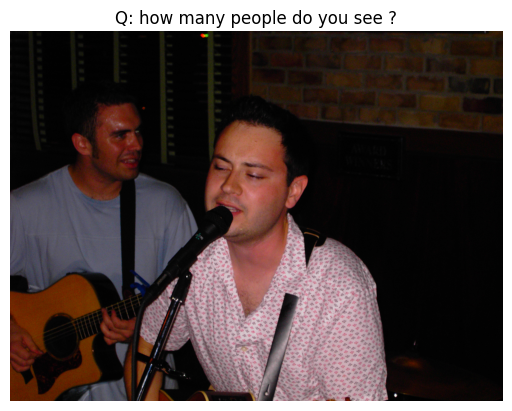

there are two people in the picture.


In [16]:
img   = '/Users/saptarshimallikthakur/Pictures/VLM/nanovlm/vikhyatk_inqa/train-00000-of-00199/753c0955fa7028c5.jpg' #"/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "how many people do you see ?"
print(generate_answer(vlm, img, ques, temp=1.0))

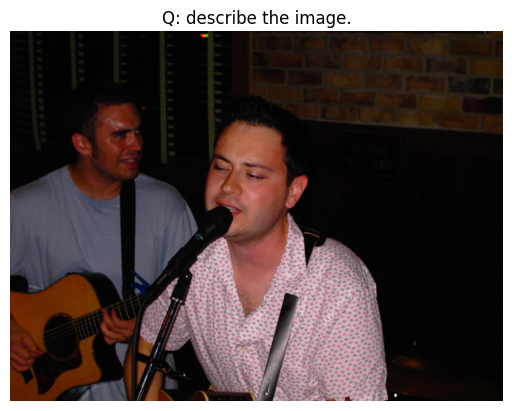

The image is a portrait of a person, who is wearing a white shirt, black trousers, and a black hat.


In [17]:
img   = '/Users/saptarshimallikthakur/Pictures/VLM/nanovlm/vikhyatk_inqa/train-00000-of-00199/753c0955fa7028c5.jpg' #"/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "describe the image."
print(generate_answer(vlm, img, ques, temp=1.0))

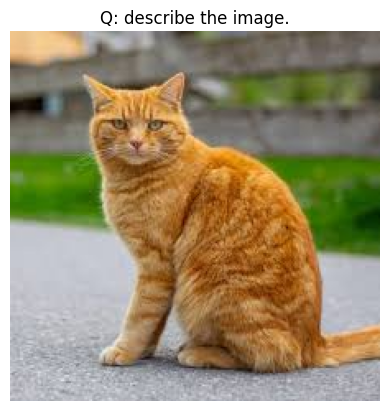

there are trees in the background. the sky is blue. there are birds in the distance.


In [18]:
img   = "/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "describe the image."
print(generate_answer(vlm, img, ques, temp=1.0))

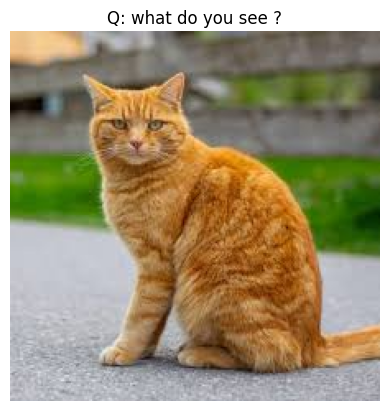

I see a bird eating its food.


In [19]:
img   = "/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "what do you see ?"
print(generate_answer(vlm, img, ques, temp=1.0))

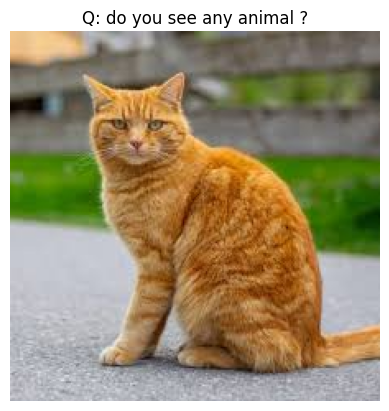

yes, it features multiple animals.


In [20]:
img   = "/Users/saptarshimallikthakur/Pictures/New Folder With Items/cat.jpeg"
ques  = "do you see any animal ?"
print(generate_answer(vlm, img, ques, temp=1.0))

In [21]:
save_path = "vlm_trained_weights_stage1.pt"
torch.save(vlm.state_dict(), save_path)
print(f"\n✅ Training completed. Trainable weights saved to: {save_path}")


✅ Training completed. Trainable weights saved to: vlm_trained_weights_stage1.pt
